In [1]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import glob
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

/home/allen/anaconda3/envs/dlcv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_batchsz, val_batchsz = 16, 16
epoch = 120
numofclass = 50
hw1train_path = "/data/dlcv/hw1/hw1_data/p1_data/train_50/"
hw1val_path = "/data/dlcv/hw1/hw1_data/p1_data/val_50/"
checkpoint_path = "/data/allen/hw1model/fromscratch.pth"
log_path = "/data/allen/hw1model/fromscratch_log.txt"

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    torch.cuda.set_device(4)
print('Device used:', device)

Device used: cuda


In [3]:
class Mydataset(Dataset):
    def __init__(self, dirpath, transform=None):
        self.data = []
        self.transform = transform
        filenames = glob.glob(os.path.join(dirpath, "*.png"))
        for filename in filenames:
            image_fn = os.path.split(filename)[1]
            label = int(image_fn.split("_")[0])
            self.data.append((filename, label)) #filename, label
        self.len = len(self.data)

    def __getitem__(self, index):
        """ Get a sample from the dataset """
        image_fn, label = self.data[index]
        image = Image.open(image_fn)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        """ Total number of samples in the dataset """
        return self.len

In [4]:
train_tfm = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=3),
    transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.5),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.PILToTensor()
])
val_tfm = transforms.Compose([
    transforms.PILToTensor()
])
trainset, valset = Mydataset(hw1train_path, transform=train_tfm), Mydataset(hw1val_path, transform=val_tfm)
trainset_loader = DataLoader(trainset, batch_size=train_batchsz, shuffle=True, num_workers=1)
valset_loader = DataLoader(valset, batch_size=val_batchsz, shuffle=False, num_workers=1)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.5)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.5),
            nn.ReLU(),
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.5),
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.MaxPool2d((2,2))
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.5),
            nn.ReLU(),
            nn.MaxPool2d((2,2))
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8*8*32, 8*8*32),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(8*8*32, 50)
        
    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(F.relu(x1+x2))
        x4 = self.conv4(x3)
        x5 = self.conv5(F.relu(x3+x4))
        x6 = self.conv6(x5).flatten(1)
        fc1 = self.fc1(x6)
        return self.fc2(fc1), fc1

In [6]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'model_state_dict': model.state_dict(),
             'optimizer_state_dict' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to {}'.format(checkpoint_path))

In [7]:
def loadbestacc():
    best_acc = 0.
    if os.path.exists(log_path):
        with open(log_path, "r") as f:
            for line in f.readlines():
                linelist = line.split(" ")
                if linelist[0] == checkpoint_path:
                    best_acc = float(linelist[-1].strip("%"))
                    break
    return best_acc / 100.

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def train_save(model, optimizer):
    lrscheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,100,135], gamma=0.6)
    criterion = nn.CrossEntropyLoss()
    best_acc = loadbestacc()
    colors = np.random.rand(len(valset_loader.dataset), 3)
    print("best_acc = {:.3%}".format(best_acc))
    for ep in range(epoch):
        model.train()  # set training mode
        train_loss, train_acc = 0., 0.
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.long)
            output, __ = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += (output.argmax(-1) == target).float().sum()
        lrscheduler.step()
        train_loss /= len(trainset_loader.dataset)
        train_acc /= len(trainset_loader.dataset)
        
        model.eval()
        val_loss, val_acc = 0., 0.
        groundtruth, last2layer =[], []
        pca, tsne = PCA(n_components=2), TSNE(n_components=2, learning_rate='auto', init='random') 
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valset_loader):
                data, target = data.to(device, dtype=torch.float32), target.to(device, dtype=torch.long)
                output, last2 = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                val_acc += (output.argmax(-1) == target).float().sum()
                if ep == 0 or ep == 30 or ep == epoch - 1:
                    groundtruth.append(target.detach().cpu().numpy())
                    last2layer.append(last2.detach().cpu().numpy())
        val_loss /= len(valset_loader.dataset)
        val_acc /= len(valset_loader.dataset)
        
        if ep == 0 or ep == 30 or ep == epoch - 1:
            groundtruth, last2layer = np.concatenate(groundtruth), np.concatenate(last2layer)
            # print(groundtruth.shape, last2layer.shape)
            afterpca, aftertsne = pca.fit_transform(last2layer), tsne.fit_transform(last2layer)
            fig1, fig2 = plt.figure(1), plt.figure(2)
            ax1, ax2 = fig1.add_subplot(111), fig2.add_subplot(111)
            ax1.set_title('PCA'), ax2.set_title('t-SNE')
            for i, data in enumerate(afterpca):
                x, y, class_ = data[0], data[1], groundtruth[i]
                ax1.scatter(x, y, color=tuple(colors[class_]), s=5)
            for i, data in enumerate(aftertsne):
                x, y, class_ = data[0], data[1], groundtruth[i]
                ax2.scatter(x, y, color=tuple(colors[class_]), s=5)
            fig1.savefig(os.path.join(os.path.split(checkpoint_path)[0], "PCA_epoch{}.png".format(ep)))
            fig2.savefig(os.path.join(os.path.split(checkpoint_path)[0], "tsne_epoch{}.png".format(ep)))
            plt.show()
        print("Epoch {} train loss = {:.6f}, train acc = {:.3%}, valid loss = {:.6f}, valid acc = {:.3%}".format(ep + 1, train_loss, train_acc, val_loss, val_acc))        
        if val_acc > best_acc:
            save_checkpoint(checkpoint_path, model, optimizer)
            with open(log_path, "w") as f:    
                f.write("{} : {:.3%}".format(checkpoint_path, val_acc))
            best_acc = val_acc

best_acc = 54.240%


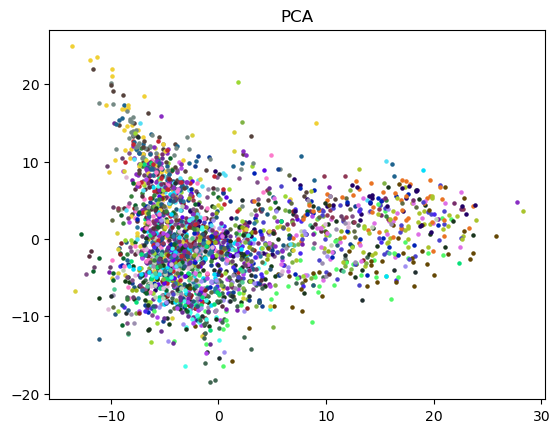

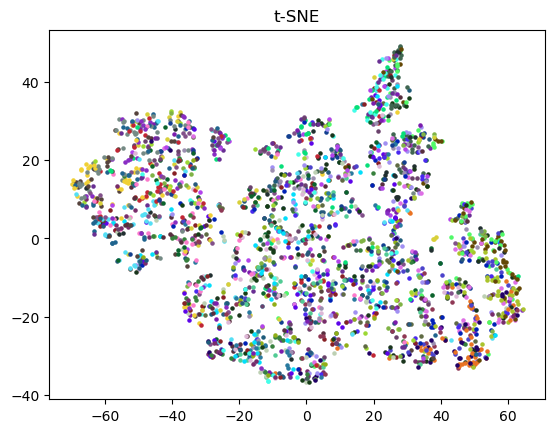

Epoch 1 train loss = 0.230864, train acc = 6.213%, valid loss = 0.209205, valid acc = 11.920%
Epoch 2 train loss = 0.210781, train acc = 12.262%, valid loss = 0.198401, valid acc = 16.640%
Epoch 3 train loss = 0.202503, train acc = 15.458%, valid loss = 0.190296, valid acc = 19.520%
Epoch 4 train loss = 0.195871, train acc = 17.440%, valid loss = 0.182924, valid acc = 21.680%
Epoch 5 train loss = 0.190156, train acc = 19.556%, valid loss = 0.177311, valid acc = 24.360%
Epoch 6 train loss = 0.184197, train acc = 21.787%, valid loss = 0.170802, valid acc = 26.200%
Epoch 7 train loss = 0.179669, train acc = 23.507%, valid loss = 0.167506, valid acc = 28.040%
Epoch 8 train loss = 0.175691, train acc = 25.071%, valid loss = 0.164260, valid acc = 29.280%
Epoch 9 train loss = 0.172656, train acc = 26.231%, valid loss = 0.166193, valid acc = 29.040%
Epoch 10 train loss = 0.169715, train acc = 27.284%, valid loss = 0.158118, valid acc = 32.560%
Epoch 11 train loss = 0.166458, train acc = 28.840

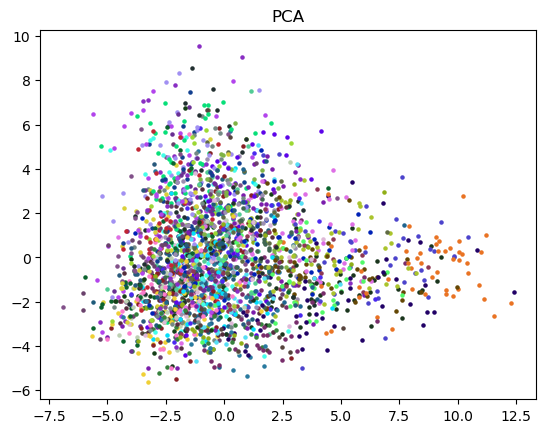

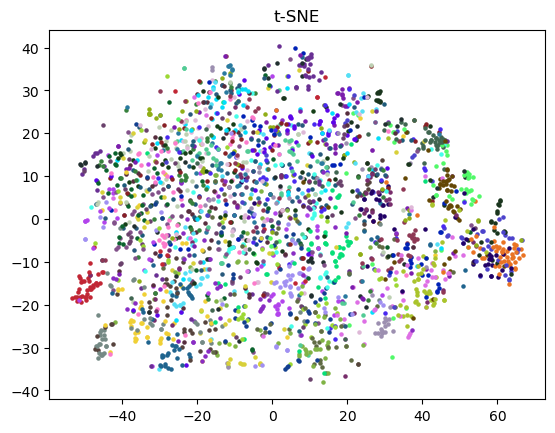

Epoch 31 train loss = 0.132050, train acc = 41.596%, valid loss = 0.127617, valid acc = 44.320%
Epoch 32 train loss = 0.130430, train acc = 41.947%, valid loss = 0.129941, valid acc = 43.480%
Epoch 33 train loss = 0.129884, train acc = 42.458%, valid loss = 0.125451, valid acc = 45.360%
Epoch 34 train loss = 0.129054, train acc = 42.778%, valid loss = 0.126421, valid acc = 45.720%
Epoch 35 train loss = 0.127733, train acc = 43.280%, valid loss = 0.125910, valid acc = 45.400%
Epoch 36 train loss = 0.127044, train acc = 43.587%, valid loss = 0.126626, valid acc = 44.880%
Epoch 37 train loss = 0.125660, train acc = 44.058%, valid loss = 0.124696, valid acc = 46.600%
Epoch 38 train loss = 0.124211, train acc = 44.564%, valid loss = 0.124304, valid acc = 46.560%
Epoch 39 train loss = 0.123285, train acc = 44.871%, valid loss = 0.125521, valid acc = 45.320%
Epoch 40 train loss = 0.122378, train acc = 45.596%, valid loss = 0.122903, valid acc = 45.960%
Epoch 41 train loss = 0.121995, train ac

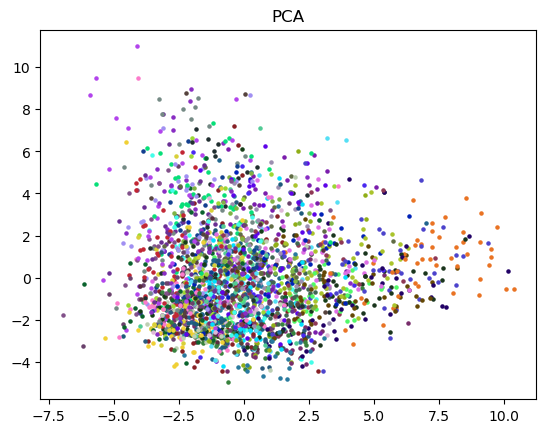

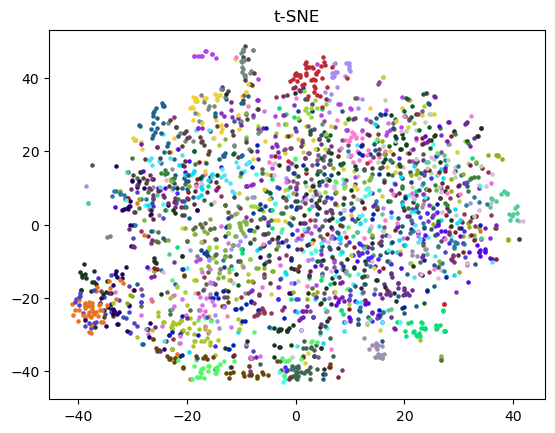

Epoch 120 train loss = 0.073773, train acc = 64.720%, valid loss = 0.118539, valid acc = 51.200%


In [9]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters())
train_save(model, optimizer)